## 1. Define Function

In [129]:
import numpy as np
from numba import jit
from scipy.special import comb
import scipy.optimize as optimize
from matplotlib import pyplot as plt
import numpy.polynomial.polynomial as nppp
%matplotlib inline

In [96]:
#return interst rate of each node
@jit
def generateBTR(r0,drift,sigma,n,year): 
    n_level = n * year
    BT = np.zeros((n_level, n_level))
    BT[0][0] = r0
    deltaT=1/n
    for i in range(1, n_level):
        BT[:, i] = BT[:, i - 1] * np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        BT[i][i] = BT[i - 1][i - 1] * np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
    return BT

#return discount rate between each deltaT
@jit
def generateBT(r0,drift,sigma,n,year): 
    BTR = generateBTR(r0,drift,sigma,n,year)
    deltaT=1/n
    return np.exp(-BTR*deltaT)

@jit
def discountedValue(BT,n):
    result = BT[:n, n - 1]
    for i in np.arange(n-1,0,-1):
        result = 0.5 * (result[:-1] + result[1:]) * BT[:i, i - 1]
    return result[0]

'''
r0=current continous conpouding short rate
drift,sigma=parameters in model
n=numer of steps in year
year=matirity
cFrq=how many times of coupon payment per year
c=coupon rate
principle=face value
'''
@jit
def vanillaBond(r0,drift,sigma,n,year,cFrq,c,principle):
    BT=generateBT(r0,drift,sigma,n,year)
    price=principle*discountedValue(BT,year*n) 
    for t in np.array(range(1,cFrq*year+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BT,int(t*n))  
    return price

@jit
def callableBond(r0,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime):
    
    BTRt=generateBTR(r0,drift,sigma,n,callTime)
    BTt=generateBT(r0,drift,sigma,n,callTime)
    
    newR=BTRt[:, n*callTime - 1].squeeze()
    len_newR = len(newR)
    
    price=0
    count=0
    for r in newR:
        p1=min(vanillaBond(r,drift,sigma,n,year-callTime,cFrq,c,principle),callPirce)
        price+=p1*discountedValue(BTt,callTime*n)*comb(len_newR-1, count)/(2**(len(newR)-1))
        count+=1
        
    for t in np.arange(1,cFrq*callTime+1)/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BTt,int(t*n))  
    return price

def ytm(price,c,principle,cFrq,year):
    
    freq = float(cFrq)
    periods = year*freq
    coupon = c*principle/cFrq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + principle/(1+y/freq)**(freq*year) - price
    
    return optimize.newton(ytm_func, 0.03)

## 2. Simulate vanilla bond price

In [167]:
drift=0.01
sigma=0.4
n=6
year=30
cFrq=2
c=0.03
principle=100
callPirce=101
callTime=3

In [75]:
%timeit vanillaBond(0.0001,drift,sigma,n,year,cFrq,c,principle)

6.24 ms ± 51.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
%timeit vanillaBond(0.0001,drift,sigma,n,year,cFrq,c,principle)

6.16 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit generateBT(0.0001,drift,sigma,n,year)

1.99 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
p = vanillaBond(0.0001,drift,sigma,n,year,cFrq,c,principle)
%timeit ytm(p,c,principle,cFrq,year)

291 µs ± 614 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime)

107 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
%timeit callableBond(0.0001,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime)

2.32 ms ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


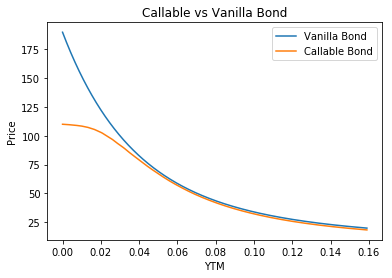

In [168]:
y=[]
price=[]
priceC=[]
for r in np.arange(0, 0.2, 0.0001):
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    price.append(p)
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
plt.figure(figsize=(6,4))    
plt.plot(y,price,label='Vanilla Bond') 
plt.plot(y,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('YTM')
plt.ylabel('Price')
plt.legend()
plt.show()

In [169]:
price = np.array(price)
priceC = np.array(priceC)
y = np.array(y)

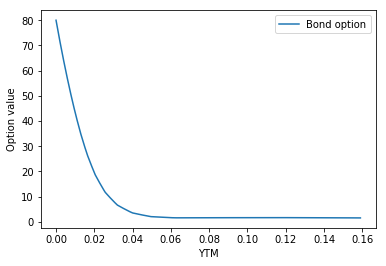

In [170]:
option_value = price - priceC
plt.figure(figsize=(6,4))    
plt.plot(y,option_value,label='Bond option')
plt.xlabel('YTM')
plt.ylabel('Option value')
plt.legend()
plt.show()

# local smooth function - useless

In [130]:
import numpy as np
    
def localSmooth(x, y, w = 20, n = 4):
    '''Fit a polynomial with order = n locally to each of the sets of consecutive points of window size = w'''
    length = len(x)
    
    polys = []
    for i in np.arange(length - w):
        polys.append(nppp.polyfit(x[i:i + w], y[i:i + w], n))
        
    return np.array(polys)

def calcDerivative(smoothedPolys, x, w = 20, n = 4):
    '''Calculate the first derivative of locally smoothed functions from localSmooth.
    for all points in x, if x is at the middle of a local polynomial, calculate its derivative with that polynomial
    else find a polynomial in which it is nearest to the middle 
    '''
    
    lp = len(smoothedPolys)
    
    res = []
    for i in x:
        # find polynomial
        if i < w // 2:
            poly = smoothedPolys[0]
        elif i - w // 2 > lp - 1:
            poly = smoothedPolys[lp - 1]
        else:
            poly = smoothedPolys[i - w // 2]
            
        # calculate derivative
        res.append(np.polyval(poly[:-1] * np.arange(n,0,-1), i))
        
    return np.array(res)

In [113]:
window = 5
polys = localSmooth(y, priceC, window)

ex = polys[499 - 5 // 2]
np.sum(ex * 0.05**np.arange(4, -1, -1))

67.625796796669846

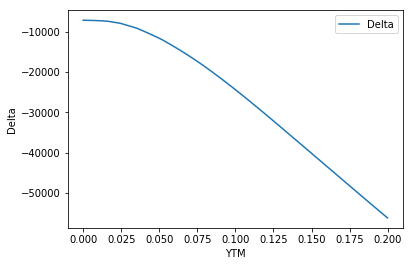

In [133]:
window = 20
order = 4

polys = localSmooth(y, priceC, window, order)
derivatives = calcDerivative(polys, y, window, order)
duration = - derivatives / priceC

disc1 = 1
plt.figure(figsize=(6,4))    
plt.plot(y, duration,label='Delta')
plt.xlabel('YTM')
plt.ylabel('Delta')
plt.legend()
plt.show()

# naive moving average

In [151]:
def smooth_ave(d, period = 3):
    length = len(d)
    res = np.zeros(length - (period - 1))
    for i in np.arange(period - 1):
        res += d[i:i - period + 1]
        
    res += d[period - 1:length]
    return res / period

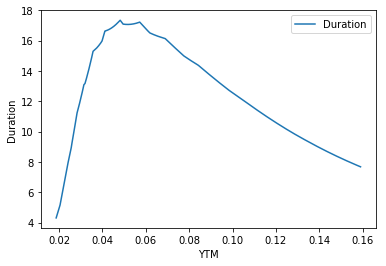

In [181]:
period = 100
priceC_sm = smooth_ave(priceC, period)
disc1 = 1
new_y = y[period - 1:]
delta = -((priceC_sm[disc1:] - priceC_sm[:-disc1]) / (priceC_sm[:-disc1])) / (new_y[disc1:] - new_y[:-disc1])
new_yy = new_y[disc1:]
plt.figure(figsize=(6,4))    
plt.plot(new_yy,delta,label='Duration')
plt.xlabel('YTM')
plt.ylabel('Duration')
plt.legend()
plt.show()

1691


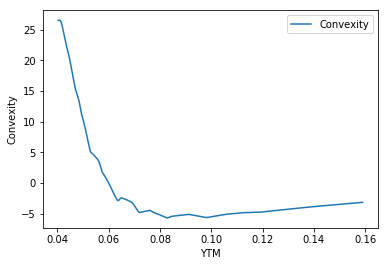

In [182]:
disc2 = 10
period2 = 200
delta_sm = smooth_ave(delta, period2)
gamma = (delta_sm[disc2:] - delta_sm[:-disc2]) / (new_yy[disc2 + period2 - 1:] - new_yy[:-disc2-period2+1])

print(len(gamma))

plt.figure(figsize=(6,4))    
plt.plot(new_yy[disc2 + period2 - 1:],gamma,label='Convexity')
plt.xlabel('YTM')
plt.ylabel('Convexity')
plt.legend()
plt.show()

# fit entire curve - disaster

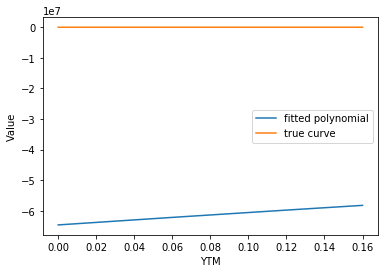

In [150]:
order = 6
poly = nppp.polyfit(y, priceC, order)
fitted_val = np.polyval(poly, y)

plt.figure(figsize=(6,4))    
plt.plot(y, fitted_val, label='fitted polynomial')
plt.plot(y, priceC, label='true curve')
plt.xlabel('YTM')
plt.ylabel('Value')
plt.legend()
plt.show()